In [1]:
! pip install pylibjpeg -q
! pip install python-gdcm -q
! pip install pylibjpeg-libjpeg -q

In [2]:
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastcore.all import *

import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from skimage.transform import resize

# Use the predictions to extract only cspine images

8 sagittal slices were used for each exam because 16 caused memory issues. 
The prediction masks need to be transformed to match the images and can then be used to get the cspine vs non cspine regions.

The next step is to test to see if we can get away with even less sagittal slices which will decrease prediction time on the test set. We will experiment with 4 and compare.

Result: 4 works just as well as 8 with half the predictions needed.

In [3]:
root = Path('../input/rsna-2022-cervical-spine-fracture-detection/train_images')
jpg_root = Path('../input/segment-cspine-notebook-2-2')
csv_root = Path('../input/cspine-csvs')

seg_path = Path('../input/rsna-2022-cervical-spine-fracture-detection/segmentations')
segmentations = list(seg_path.iterdir())
seg_ids = [o.stem for o in segmentations]

exclude = '1.2.826.0.1.3680043.20574'

## Load csvs

'Study ranges with cspine' has the range predictions from a model that classifies axial slices as cspine or not

'Train dcm filenames' has the study id and slice number of every file in the train_images folder

In [4]:
rdf = pd.read_csv('../input/cspine-csvs/study_ranges_with_cspine.csv')
df = pd.read_csv(csv_root/'train_dcm_filenames.csv')
df.head()

,study_id,slice
0,1.2.826.0.1.3680043.10001,1
1,1.2.826.0.1.3680043.10001,2
2,1.2.826.0.1.3680043.10001,3
3,1.2.826.0.1.3680043.10001,4
4,1.2.826.0.1.3680043.10001,5


## Get the count for each study id

In [5]:
count_df = df.groupby('study_id').count().reset_index()
count_df.rename(columns = {'slice':'n'}, inplace=True)
#remove excluded case
count_df = count_df[count_df.study_id != exclude]
#study_ids
study_ids = count_df.study_id.to_list()
count_df.head()

,study_id,n
0,1.2.826.0.1.3680043.10001,268
1,1.2.826.0.1.3680043.10005,259
2,1.2.826.0.1.3680043.10014,258
3,1.2.826.0.1.3680043.10016,645
4,1.2.826.0.1.3680043.10032,321


## Utility functions

In [6]:
def get_fn(study_id, n, ext = '.dcm'):
    if ext == '.dcm':
        return root/study_id/f'{n}{ext}'
    else:
        return jpg_root/(study_id + f'_{n}{ext}')
    
def show_case(study_id, aspect = 2):
    fig, axs = plt.subplots(4,4, figsize=(16, 12))
    axs = axs.flatten()
    for i in range(0, len(axs), 2):
        fn = get_fn(study_id, int(i/2), '.jpg')
        img,mask = image_and_mask(fn)
        axs[i].imshow(img, cmap='bone')
        axs[i+1].imshow(mask)
     
        axs[i].axis("off")
        axs[i].set_aspect(aspect)
        axs[i+1].axis("off")
        axs[i+1].set_aspect(aspect)
        
    plt.show()

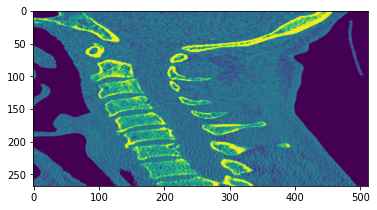

In [7]:
fn = Path(jpg_root/'1.2.826.0.1.3680043.10001_4.jpg')
im = Image.open(fn)
plt.imshow(im)

# Get the Z order of the images and sort from head to toe

In [8]:
def get_meta_zpos(fn):
    ds = pydicom.dcmread(fn, stop_before_pixels=True)
    if 'ImagePositionPatient' not in ds:
        print('no position')
    pos = ds.ImagePositionPatient[2]
    return pos

# get z position of first and last slice and compare, largest is more cranial
def add_order(df):
    grouping = df.groupby('study_id')['slice']
    order_seq = []
    for study_id,g in grouping:
        fn1 = get_fn(study_id, g.values[0])
        fn2 = get_fn(study_id, g.values[-1])
        pos1 = get_meta_zpos(fn1)
        pos2 = get_meta_zpos(fn2)

        #head first
        if pos1 > pos2:
            order = [o + 1 for o in range(len(g))]
        else:
            order = [o + 1 for o in reversed(range(len(g)))]
        order_seq += order
    return order_seq

NEEDS_CSV = False
if NEEDS_CSV == True:
    #all train dcm filenames
    tdf = pd.read_csv('../input/cspine-csvs/train_dcm_filenames.csv')
    tdf = tdf.sort_values(['study_id','slice'])

    #add order from head to thorax
    tdf['order'] = add_order(tdf)
    print(tdf.tail())
    tdf.to_csv('train_dcm_filenames_ordered.csv',index=False)
else:
    tdf = pd.read_csv(csv_root/'train_dcm_filenames_ordered.csv') 

In [9]:
tdf[(tdf.slice != tdf.order)].study_id.nunique()

206

In [10]:
study_id = '1.2.826.0.1.3680043.10001'

# Transform resized and padded masks back to the image original shape

In [11]:
def get_padding(img):
    r,c = img.shape
    pad = int((abs(c-r)/2))
    if img.shape[1] > img.shape[0]:
        top, right, bottom, left = pad,0,abs(c-r)- pad,0
    else:
        top, right, bottom, left  = 0,pad,0,abs(c-r) - pad 
    return top, right, bottom, left 

#reverse image transforms from model prediction
def image_and_mask(fn):
    #image
    img = mpimg.imread(fn.with_suffix('.jpg'))
    #get padding to be removed from mask
    top, right, bottom, left = get_padding(img)
    #mask - resize then remove padding
    mask = np.load(fn.with_suffix('.npy'))
    square_size = (max(img.shape),max(img.shape))
    mask = resize(mask, square_size, anti_aliasing=True, preserve_range=True)
    mask = mask.astype(int)
    r,c = mask.shape
    mask = mask[top:r - bottom, left:c - right]
    return img, mask


# Example of a case that's not centered

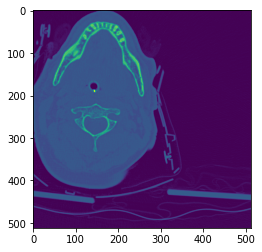

In [12]:
fn = get_fn('1.2.826.0.1.3680043.11401',250)
ds = pydicom.dcmread(fn)
im = ds.pixel_array
plt.imshow(im)

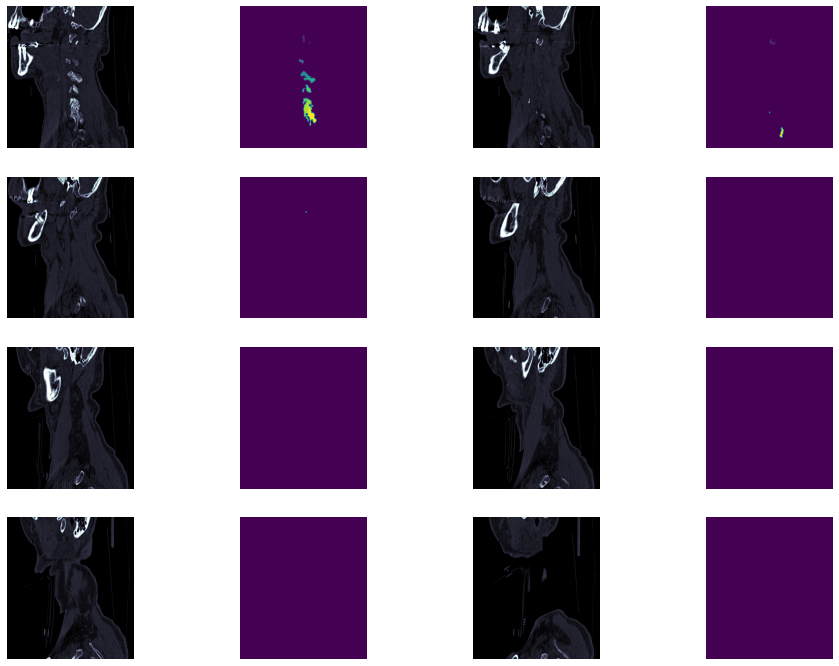

In [13]:
#8693, 11401
show_case('1.2.826.0.1.3680043.11401', 1.5)

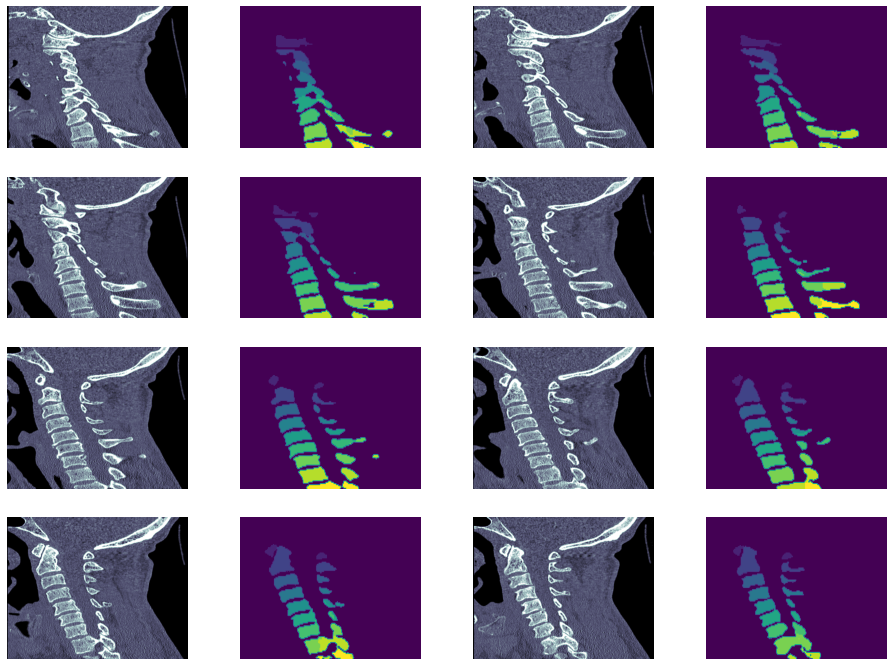

In [14]:
#typical case
show_case('1.2.826.0.1.3680043.10001', 1.5)

# Get axial indices from sagittal slices

Get the range of slices containing cspine (labels 1-7)
Make sure the cspine is completely represented in the mask prediction, otherwise use the entire study

In [15]:
def get_mask_range(mask):
    rows = [i for i, row in enumerate(mask) if row.max() > 0]
    if len(rows) == 0:
        return 0, mask.shape[0]
    else:
        return min(rows), max(rows)
    
def get_index_from_slice(study_id, slice):
    #get index by comparing slices to sort order
    index = tdf[(tdf.study_id == study_id) & (tdf.slice == slice)].values[0][-1]
    return index

def get_range_from_nii(study_id):
    #read from range df created from segmentation files to get slice names
    _,top,bottom = rdf[rdf.study_id == study_id].values[0]
    #get index by comparing slices to sort order
    top_index = get_index_from_slice(study_id, top)
    bottom_index = get_index_from_slice(study_id, bottom)
    return top_index,bottom_index
    
def get_range_of_included(study_id, n_masks = 8):
    if study_id in seg_ids:
        top, bottom = get_range_from_nii(study_id)
    else:
        #get all masks
        mask_fns = jpg_root.glob(study_id + '_*.npy')
        if n_masks == 4:
            tmp = []
            sag_slices = [0,3,5,7]
            for fn in mask_fns:
                slice = int(fn.stem.split('_')[1])
                if slice in sag_slices:
                    tmp.append(fn)
            if len(tmp) == 0:
                print('error')
            mask_fns = tmp
        top = 0
        bottom = 100000
        #check if all cspine imaged
        labels = { 1, 2, 3, 4, 5, 6, 7}
        c = set()
        for fn in mask_fns:
            _,mask = image_and_mask(fn)
            one,two = get_mask_range(mask)
            x = set(mask.flatten())
            c.update(x)
            top = max(top,one)
            bottom = min(bottom,two)
        if c.intersection(labels) != labels:
            print('Incomplete mask', c, study_id)
            return 0, mask.shape[0]
    return top, bottom

In [16]:
study_id = '1.2.826.0.1.3680043.10001'

# Get list of images to keep based on results using 8 sagittal slices per study

In [17]:
# add keep column
fn = Path('../input/cspine-csvs/keep_8_seg_pred.csv')
if fn.exists():
    tdf = pd.read_csv(fn)
else:
    grouped = tdf.groupby('study_id')

    keep_list = []
    for study_id, g in grouped:
        top, bottom = get_range_of_included(study_id)
        items = g.order.tolist()
        keep = [((int(item) >= top) and (int(item) <= bottom)) for item in items]

        keep_list.extend(keep)

    tdf['keep_8'] = keep_list
    tdf.to_csv('keep_8_seg_pred.csv',index=False)
    tdf.head()

In [18]:
tdf.keep.value_counts()

True     519493
False    192108
Name: keep, dtype: int64

# Get list of images to keep based on results using only 4 sagittal slices per study

In [19]:
# evaluate to see if 4 images will get close to the same results
fn = Path('../input/cspine-csvs/keep_4_seg_pred.csv')
if fn.exists():
    tdf = pd.read_csv(fn)
else:
    grouped = tdf.groupby('study_id')

    keep_list = []
    for study_id, g in grouped:
        top, bottom = get_range_of_included(study_id, n_masks=4)
        items = g.order.tolist()
        keep = [((int(item) >= top) and (int(item) <= bottom)) for item in items]

        keep_list.extend(keep)

    tdf['keep_4'] = keep_list
    tdf.to_csv('keep_4_seg_pred.csv',index=False)
    tdf.head()

In [20]:
tdf.keep_4.value_counts()

True     523244
False    188357
Name: keep_4, dtype: int64

# Keep list from prior notebook which made predictions on individual images

In [21]:
#compare to rdf
fn = Path('../input/cspine-csvs/keep_variations.csv')
if fn.exists():
    tdf = pd.read_csv(fn)
else:
    grouped = tdf.groupby('study_id')

    keep_list = []
    for study_id, g in grouped:
        #ranges df
        row = rdf[rdf.study_id == study_id].values[0]
        #print(row, row[2] + 1 - row[1])
        top = row[1]
        bottom = row[2]
        items = g.slice.tolist()
        #print(len(items))
        keep = [((int(item) >= top) and (int(item) <= bottom)) for item in items]
        #print(len([o for o in keep if o == True]))
        assert row[2] + 1 - row[1] == len([o for o in keep if o == True]), f'Discrepancy {study_id}'
        keep_list.extend(keep)

    tdf['keep_slice_pred'] = keep_list
    tdf.columns = ['study_id', 'slice', 'order', 'keep_8', 'keep_4', 'keep_slice_pred']
    tdf.to_csv('keep_variations.csv',index=False)
 

In [22]:
tdf.keep_slice_pred.value_counts()

True     477661
False    233940
Name: keep_slice_pred, dtype: int64

# Comparison

Using only 4 images gives similar results. 3751 (523244 - 519493) extra images are kept compared to using 8 sagittal slices. Either way, you would want to give a top and bottom margin and include extra images.

The slices bases on the notebook 'CSpine Reduce Data by 1/3' has the tightest predictions with more excluded slices. The training took longer and gave no information on CSpine levels.

## Final assessment:

Predictions with 4 sagittal images spaced at 24 pixels apart gave the most info in the shortest amount of time

In [23]:
# show mask images for include from all 3 methods

#reverse image transforms from model prediction
def transform_mask(fn, top, bottom):
    #mask - resize then remove rows
    mask = np.load(fn.with_suffix('.npy'))
    square_size = (max(img.shape),max(img.shape))
    mask = resize(mask, square_size, anti_aliasing=True, preserve_range=True)
    mask = mask.astype(int)
    r,c = mask.shape
    mask = mask[top:r - bottom, left:c - right]
    return mask

In [24]:
tdf.columns

Index(['study_id', 'slice', 'order', 'keep', 'keep_4', 'keep_slice_pred'], dtype='object')

In [25]:
def get_range_for_column(column, study_id):
    study = tdf[(tdf.study_id == study_id)]
    keep_indices = [row['order'] for _,row in study.iterrows() if row[column] == True]
    if len(keep_indices) == 0:
        print('keep none', study_id)
        return 1,len(study)
    top_index = min(keep_indices)
    bottom_index = max(keep_indices)
    return top_index, bottom_index
    
    
def show_keep(study_ids, slice = 3, aspect = 2):
    fig, axs = plt.subplots(6,3, figsize=(12, 16))
    axs = axs.flatten()
    for i in range(0, len(axs), 3):
        study_id = study_ids[int(i/3)]
        fn = get_fn(study_id, slice, '.jpg')

#         assert img.shape[0] ==  count_df[count_df.study_id== study_id].values[0][1], 'Shape does not match'
        
        columns = tdf.columns[-3:] #['keep', 'keep_4', 'keep_slice_pred']
        for j, column in enumerate(columns):
            top,bottom = get_range_for_column(column, study_id)
            img = mpimg.imread(fn)
            img = img[top: bottom + 1]
            axs[i + j].imshow(img, cmap='bone')
            axs[i + j].axis("off")
            axs[i + j].set_title(f'{column} ({top}-{bottom})')
            axs[i + j].set_aspect(aspect)
        
    plt.show()

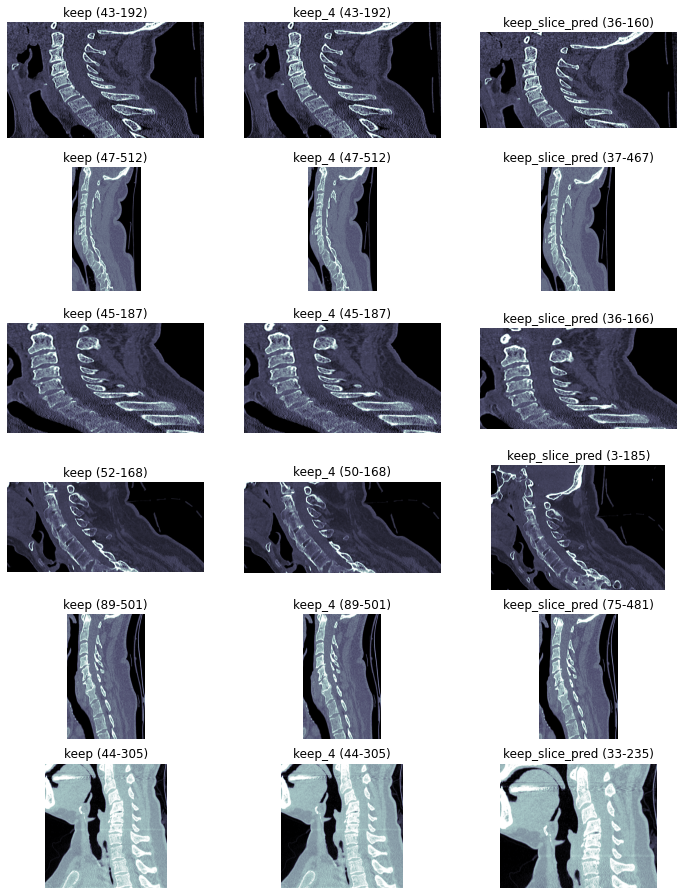

In [26]:
#show_ids = study_ids[80:86]
study_ids = np.array(study_ids)
selector = np.array([100, 20,30, 1889, 500,550],int)
#ind = [100, 20,30, 300, 500,550]
show_ids = study_ids[selector]
show_keep(show_ids)

In [27]:
df = rdf.copy()
df.columns = ['study_id','top_keep_slice_pred', 'bottom_keep_slice_pred']
#df = df.set_index('study_id')
df.head()        

,study_id,top_keep_slice_pred,bottom_keep_slice_pred
0,1.2.826.0.1.3680043.10001,48,236
1,1.2.826.0.1.3680043.10005,3,201
2,1.2.826.0.1.3680043.10014,48,251
3,1.2.826.0.1.3680043.10016,111,505
4,1.2.826.0.1.3680043.10032,69,289


In [28]:
fn = Path('../input/cspine-csvs/ranges.csv')
if fn.exists():
    df = pd.read_csv(fn)
else:
    print('Retrieving range_8')
    df['range_8'] = [get_range_for_column('keep', study_id) for study_id in df.study_id.unique()]
    print('Retrieving range_4')
    df['range_4'] = [get_range_for_column('keep_4', study_id) for study_id in df.study_id.unique()]
    print('Separate columns')
    df['top_8'] = [item[0] for _,item in df.range_8.iteritems()]
    df['bottom_8'] = [item[1] for _,item in df.range_8.iteritems()]
    df['top_4'] = [item[0] for _,item in df.range_4.iteritems()]
    df['bottom_4'] = [item[1] for _,item in df.range_4.iteritems()]
    df.drop(['range_8','range_4'], axis=1,inplace=True)
    df.to_csv('ranges.csv',index=False)

#add count
df = df.merge(count_df)
#add direction from df that has slice and order
head_first = []
grouped = tdf.groupby('study_id')
for study_id, g in grouped:
    head_first.append((abs(g['slice'].values[0] - g['order'].values[0])) < 10)

direction_df = pd.DataFrame({'study_id':tdf.study_id.unique(), 
                             'head_first':head_first})
df = df.merge(direction_df)
# add slice thickness
meta = pd.read_csv('../input/cspine-csvs/train_metadata.csv')
meta = meta[[ 'StudyInstanceUID','SliceThickness']]
meta.columns = ['study_id', 'thickness']
df = df.merge(meta)
df.head()

,study_id,top_keep_slice_pred,bottom_keep_slice_pred,top_8,bottom_8,top_4,bottom_4,n,head_first,thickness
0,1.2.826.0.1.3680043.10001,48,236,55,267,55,267,268,True,0.625
1,1.2.826.0.1.3680043.10005,3,201,19,141,19,141,259,True,0.625
2,1.2.826.0.1.3680043.10014,48,251,64,257,64,257,258,True,1.000
3,1.2.826.0.1.3680043.10016,111,505,131,619,125,619,645,True,0.625
4,1.2.826.0.1.3680043.10032,69,289,91,320,91,320,321,True,0.625


In [29]:
#keep_8
# keep none 1.2.826.0.1.3680043.16729
# keep none 1.2.826.0.1.3680043.30307
# keep none 1.2.826.0.1.3680043.3593
#keep_4
# keep none 1.2.826.0.1.3680043.30307
# keep none 1.2.826.0.1.3680043.3593

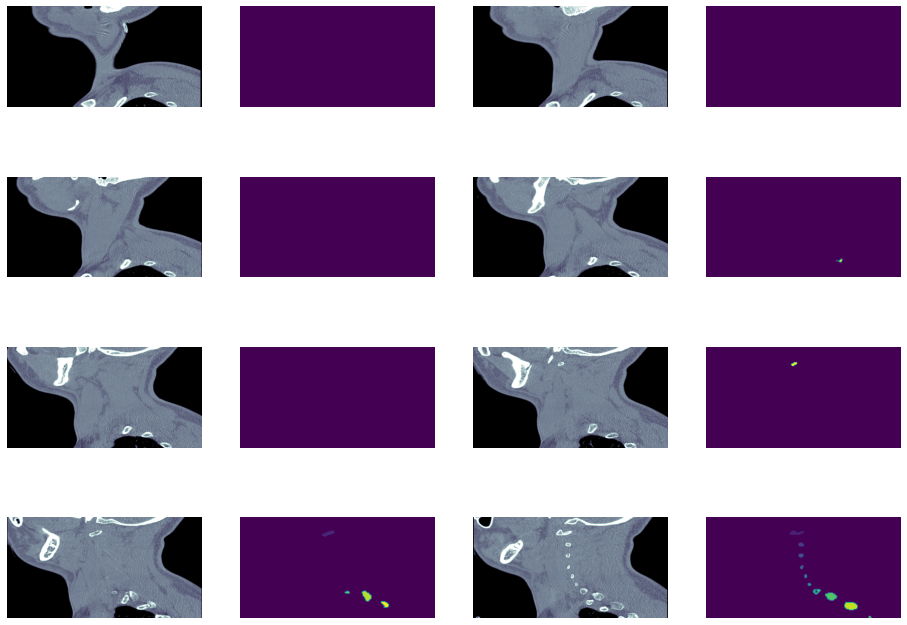

In [30]:
#Off center
show_case('1.2.826.0.1.3680043.3593', 1)

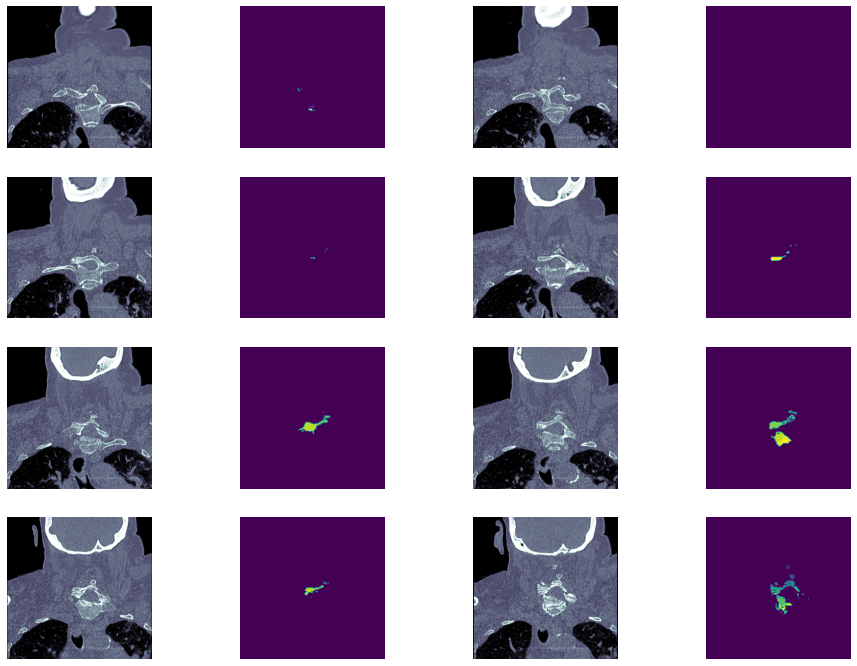

In [31]:
#Patient in decubitus position
show_case('1.2.826.0.1.3680043.16729', 1)

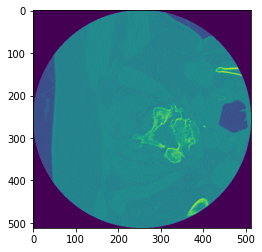

In [32]:
fn = get_fn('1.2.826.0.1.3680043.16729',250)
ds = pydicom.dcmread(fn)
im = ds.pixel_array
plt.imshow(im)

In [33]:
df[df.study_id == '1.2.826.0.1.3680043.16729']

,study_id,top_keep_slice_pred,bottom_keep_slice_pred,top_8,bottom_8,top_4,bottom_4,n,head_first,thickness
415,1.2.826.0.1.3680043.16729,113,391,1,503,290,302,503,True,0.5


In [34]:
#df.hist('top_8', bins=40), df.hist('top_4', bins=40),df.hist('top_keep_slice_pred', bins=20)

In [35]:
#df.hist('bottom_8', bins=40), df.hist('bottom_4', bins=40),df.hist('bottom_keep_slice_pred', bins=20)

<AxesSubplot:>

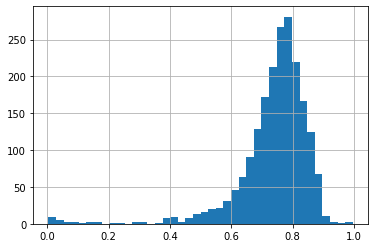

In [36]:
#total slices to keep
df['number_4'] = df.bottom_4 - df.top_4
df['number_slice'] = df.bottom_keep_slice_pred - df.top_keep_slice_pred

#identify problem cases by ratio of keep to total
df['percent'] = df['number_4']/df.n
df.percent.hist(bins=40)

In [37]:
problems = df[(df.number_4/df.number_slice < .50)]
print(len(problems))
problems.head()

31


,study_id,top_keep_slice_pred,bottom_keep_slice_pred,top_8,bottom_8,top_4,bottom_4,n,head_first,thickness,number_4,number_slice,percent
72,1.2.826.0.1.3680043.1151,124,474,426,475,426,475,563,True,0.600,49,350,0.087034
169,1.2.826.0.1.3680043.12879,58,241,240,248,238,248,257,True,0.625,10,183,0.038911
184,1.2.826.0.1.3680043.13114,58,256,72,91,72,91,260,True,0.625,19,198,0.073077
200,1.2.826.0.1.3680043.13374,38,274,209,260,209,260,352,True,0.625,51,236,0.144886
211,1.2.826.0.1.3680043.13457,69,265,215,218,215,218,336,True,0.625,3,196,0.008929


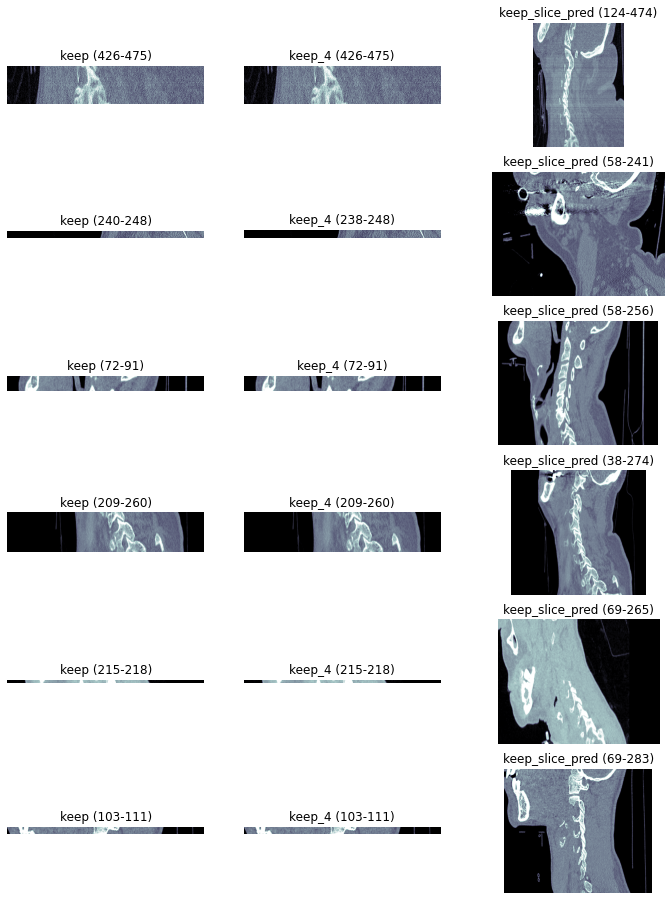

In [38]:
#show some problem cases
ids = np.array(df.study_id.tolist())
problems = problems.index
show_ids = ids[problems[:8]]
show_keep(show_ids)

In [39]:
df.head()

,study_id,top_keep_slice_pred,bottom_keep_slice_pred,top_8,bottom_8,top_4,bottom_4,n,head_first,thickness,number_4,number_slice,percent
0,1.2.826.0.1.3680043.10001,48,236,55,267,55,267,268,True,0.625,212,188,0.791045
1,1.2.826.0.1.3680043.10005,3,201,19,141,19,141,259,True,0.625,122,198,0.471042
2,1.2.826.0.1.3680043.10014,48,251,64,257,64,257,258,True,1.000,193,203,0.748062
3,1.2.826.0.1.3680043.10016,111,505,131,619,125,619,645,True,0.625,494,394,0.765891
4,1.2.826.0.1.3680043.10032,69,289,91,320,91,320,321,True,0.625,229,220,0.713396


# Percent of predictions over total images can be used to find cases where keep_4 falls short.

In [40]:
p = df[(df.percent < .35) & ((df.number_4/df.number_slice < .50))]
print(p.shape)
p.head()

(31, 13)


,study_id,top_keep_slice_pred,bottom_keep_slice_pred,top_8,bottom_8,top_4,bottom_4,n,head_first,thickness,number_4,number_slice,percent
72,1.2.826.0.1.3680043.1151,124,474,426,475,426,475,563,True,0.600,49,350,0.087034
169,1.2.826.0.1.3680043.12879,58,241,240,248,238,248,257,True,0.625,10,183,0.038911
184,1.2.826.0.1.3680043.13114,58,256,72,91,72,91,260,True,0.625,19,198,0.073077
200,1.2.826.0.1.3680043.13374,38,274,209,260,209,260,352,True,0.625,51,236,0.144886
211,1.2.826.0.1.3680043.13457,69,265,215,218,215,218,336,True,0.625,3,196,0.008929


# Predictions from slices are better at predicting C1

Add 10-15mm to the top of the keep_4 prediction to capture C1. If predictions are less than 35% of total slices, ignore and use all images.

<AxesSubplot:ylabel='Frequency'>

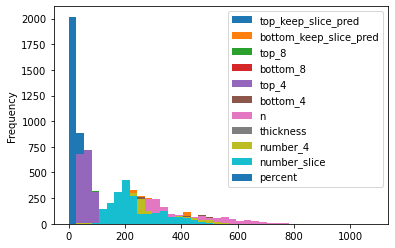

In [41]:
df.plot(kind='hist', bins=40)

In [42]:
# get slice thickness
# meta = pd.read_csv('../input/cspine-csvs/train_metadata.csv')
# meta = meta[[ 'StudyInstanceUID','SliceThickness']]
# meta.columns = ['study_id', 'thickness']
# df = df.merge(meta)
df.head()

,study_id,top_keep_slice_pred,bottom_keep_slice_pred,top_8,bottom_8,top_4,bottom_4,n,head_first,thickness,number_4,number_slice,percent
0,1.2.826.0.1.3680043.10001,48,236,55,267,55,267,268,True,0.625,212,188,0.791045
1,1.2.826.0.1.3680043.10005,3,201,19,141,19,141,259,True,0.625,122,198,0.471042
2,1.2.826.0.1.3680043.10014,48,251,64,257,64,257,258,True,1.000,193,203,0.748062
3,1.2.826.0.1.3680043.10016,111,505,131,619,125,619,645,True,0.625,494,394,0.765891
4,1.2.826.0.1.3680043.10032,69,289,91,320,91,320,321,True,0.625,229,220,0.713396


In [43]:
df = df[['study_id', 'top_4', 'bottom_4', 'n', 'number_slice',
       'number_4', 'percent', 'thickness', 'head_first']]
df.columns = ['study_id', 'top_4', 'bottom_4', 'total', 'diff_slice',
       'diff_4', 'percent_of_total', 'thickness', 'head_first']
df.head()

,study_id,top_4,bottom_4,total,diff_slice,diff_4,percent_of_total,thickness,head_first
0,1.2.826.0.1.3680043.10001,55,267,268,188,212,0.791045,0.625,True
1,1.2.826.0.1.3680043.10005,19,141,259,198,122,0.471042,0.625,True
2,1.2.826.0.1.3680043.10014,64,257,258,203,193,0.748062,1.000,True
3,1.2.826.0.1.3680043.10016,125,619,645,394,494,0.765891,0.625,True
4,1.2.826.0.1.3680043.10032,91,320,321,220,229,0.713396,0.625,True


In [44]:
# slices_to_add = [10/item for _,item in df.thickness.iteritems()]
# df['slices_to_add'] = slices_to_add
# df.slices_to_add = df.slices_to_add.astype(int)
# df.head()

# Final slices

Change problem cases to entire range
There aren't that many cases (31) so it should not have a large impact.

In [45]:
df.head()

,study_id,top_4,bottom_4,total,diff_slice,diff_4,percent_of_total,thickness,head_first
0,1.2.826.0.1.3680043.10001,55,267,268,188,212,0.791045,0.625,True
1,1.2.826.0.1.3680043.10005,19,141,259,198,122,0.471042,0.625,True
2,1.2.826.0.1.3680043.10014,64,257,258,203,193,0.748062,1.000,True
3,1.2.826.0.1.3680043.10016,125,619,645,394,494,0.765891,0.625,True
4,1.2.826.0.1.3680043.10032,91,320,321,220,229,0.713396,0.625,True


In [46]:
problems = p.index.tolist()
final_df = df.copy()
for index in problems:
    final_df.loc[index,'top_4'] = 1
    final_df.loc[index,'bottom_4'] = final_df.loc[index,'total']
    
final_df.loc[72:170]

,study_id,top_4,bottom_4,total,diff_slice,diff_4,percent_of_total,thickness,head_first
72,1.2.826.0.1.3680043.1151,1,563,563,350,49,0.087034,0.600,True
73,1.2.826.0.1.3680043.11515,84,434,435,318,350,0.804598,0.625,False
74,1.2.826.0.1.3680043.11605,62,228,246,170,166,0.674797,1.000,True
75,1.2.826.0.1.3680043.11606,51,322,323,220,271,0.839009,0.625,True
76,1.2.826.0.1.3680043.11610,52,211,212,126,159,0.750000,1.000,True
...,...,...,...,...,...,...,...,...,...
166,1.2.826.0.1.3680043.1286,50,272,297,198,222,0.747475,0.625,True
167,1.2.826.0.1.3680043.12863,59,315,316,214,256,0.810127,0.625,True
168,1.2.826.0.1.3680043.12873,102,527,539,358,425,0.788497,0.625,True
169,1.2.826.0.1.3680043.12879,1,257,257,183,10,0.038911,0.625,True


# Add padding to head

In [47]:
def new_top_bottom(row):
    amt = int(10/row.thickness)
    if head_first == True:
        return max(0,row.top_4 - amt), row.bottom_4
    else:
        return row.top_4, min(row.bottom_4 + amt, row.total)
    
final_df['new_range'] = [new_top_bottom(row) for _,row in final_df.iterrows()]
final_df['top'] = [item[0] for _,item in final_df.new_range.iteritems()]
final_df['bottom'] = [item[1] for _,item in final_df.new_range.iteritems()]
final_df = final_df[['study_id', 'top', 'bottom', 'total', 'thickness', 'head_first']]
final_df['slice_diff'] = final_df.bottom - final_df.top
final_df.head()

,study_id,top,bottom,total,thickness,head_first,slice_diff
0,1.2.826.0.1.3680043.10001,55,268,268,0.625,True,213
1,1.2.826.0.1.3680043.10005,19,157,259,0.625,True,138
2,1.2.826.0.1.3680043.10014,64,258,258,1.000,True,194
3,1.2.826.0.1.3680043.10016,125,635,645,0.625,True,510
4,1.2.826.0.1.3680043.10032,91,321,321,0.625,True,230


In [48]:
# final_df = final_df[['study_id', 'top', 'bottom', 'total', 'thickness', 'head_first']]
# final_df['slice_diff'] = final_df.bottom - final_df.top
# final_df.head()

In [49]:
final_df['slice_diff'].sum(), final_df.total.sum(), final_df['slice_diff'].sum()/ final_df.total.sum()

(544639, 711503, 0.7654767443004457)

In [50]:
#df.diff_4.sum(),df.diff_4.sum()/final_df.total.sum(), df.diff_slice.sum(), df.diff_slice.sum()/ final_df.total.sum()

In [51]:
final_df.to_csv('range_from_4_with_10mm_head_padding.csv',index=False)

In [52]:
df.describe()

,top_4,bottom_4,total,diff_slice,diff_4,percent_of_total,thickness
count,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000
mean,72.581764,331.072844,352.578295,235.664024,258.491080,0.737949,0.730737
std,39.396256,121.077095,131.920970,86.570573,101.607726,0.120985,0.185017
min,1.000000,53.000000,69.000000,51.000000,1.000000,0.003953,0.488281
25%,48.000000,246.000000,257.250000,178.000000,189.000000,0.700715,0.625000
50%,63.000000,298.000000,314.000000,213.000000,237.000000,0.759206,0.625000
75%,86.000000,398.000000,429.000000,286.000000,312.000000,0.808697,1.000000
max,426.000000,866.000000,1082.000000,859.000000,661.000000,0.996241,1.000000
